In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter, ImageEnhance
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import warnings                             
import cv2 as cv

warnings.simplefilter("ignore")                      # To suppress warnings
np.random.seed(10)
LEVEL = 'level_3'

In [2]:
class SigmoidNeuron:
  
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
    #  self.w = X.mean(axis=0)
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
      self.w -= learning_rate * dw
      self.b -= learning_rate * db
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
    
      min_key = min(loss, key=loss.get)
      print(min_key)
      print(loss.get(min_key))
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [3]:
def increase_brightness(img,value):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv.merge((h, s, v))
    image = cv.cvtColor(final_hsv, cv.COLOR_HSV2BGR)
    return image

In [4]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm_notebook(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = cv.imread(file_path)
        image = increase_brightness(image,10)                       # Increase the brightness of image
        image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)                # Convert into GrayScale
        ret,image = cv.threshold(image,25,255,cv.THRESH_BINARY)     # Binary threshold to convert image into black and white only
        image = cv.medianBlur(image,3)                              # Thicken the letter/alphabet in the image
        images[image_index] = image.flatten()      
    return images

In [5]:
languages = ['en','ta', 'hi']

images_train = read_all("../input/"+LEVEL+"_train/"+LEVEL+"/"+"background", key_prefix='bgr_') 
for language in languages:
  images_train.update(read_all("../input/"+LEVEL+"_train/"+LEVEL+"/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all("../input/"+LEVEL+"_test/kaggle_"+LEVEL, key_prefix='') 
print(len(images_test))

Reading:



Reading:



Reading:



Reading:



9000
Reading:



3000


In [6]:
list(images_test.keys())[:5]
list(images_train.keys())[2:2]
#print(images_train)
#types1 = set(type(k) for k in images_train.keys())
#print(types1)

[]

In [7]:
X_train = []
Y_train = []
for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(9000, 4096) (9000,)
(3000, 4096)


In [8]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [9]:
#sn_mse = SigmoidNeuron()
#sn_mse.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.015, loss_fn="mse", display_loss=True)

> *Splitting given training data into few random sets to verify the model (no/less overfitting) and it's accuracy on random data.*

In [10]:
sn_ce = SigmoidNeuron()

for i in range(1,4):
    X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X_scaled_train, Y_train,test_size = 0.3,random_state=i*2, stratify = Y_train)

    sn_ce.fit(X_train1, Y_train1, epochs=1, learning_rate=1,initialise = True,loss_fn="ce", display_loss=False)
   # sn_ce.fit(X_scaled_train, Y_train, epochs=200, learning_rate=0.1,initialise = False,loss_fn="ce", display_loss=True)
   # sn_ce.fit(X_scaled_train, Y_train, epochs=300, learning_rate=0.01,initialise = False,loss_fn="ce", display_loss=True)

    Y_pred_train = sn_ce.predict(X_train1)
    Y_pred_test = sn_ce.predict(X_test1)
    Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
    Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()
    accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train1)
    accuracy_test = accuracy_score(Y_pred_binarised_test, Y_test1)
    print("Train Accuracy for : ",i , accuracy_train)
    print("Test Accuracy : ",i ,accuracy_test)


Train Accuracy for :  1 0.7480952380952381
Test Accuracy :  1 0.7485185185185185



Train Accuracy for :  2 0.8111111111111111
Test Accuracy :  2 0.807037037037037



Train Accuracy for :  3 0.8074603174603174
Test Accuracy :  3 0.8118518518518518


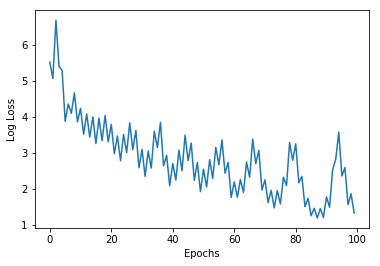

87
1.1935076726651546


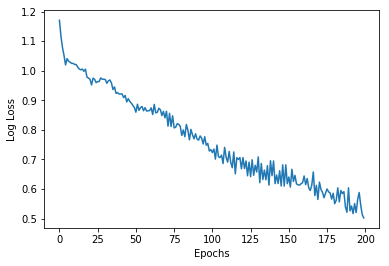

199
0.5021646408407385


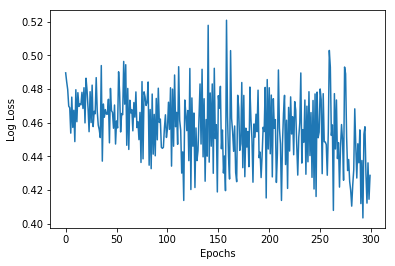

292
0.4035260336111519


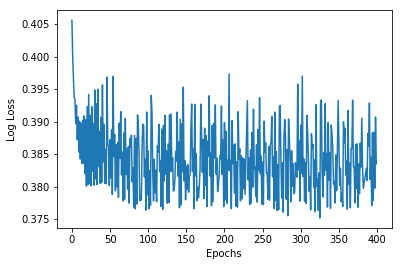

325
0.3751733038968674


In [11]:
sn_ce.fit(X_scaled_train, Y_train, epochs=100, learning_rate=1,loss_fn="ce", display_loss=True)
sn_ce.fit(X_scaled_train, Y_train, epochs=200, learning_rate=0.1,initialise = False,loss_fn="ce", display_loss=True)
sn_ce.fit(X_scaled_train, Y_train, epochs=300, learning_rate=0.01,initialise = False,loss_fn="ce", display_loss=True)
sn_ce.fit(X_scaled_train, Y_train, epochs=400, learning_rate=0.001,initialise = False,loss_fn="ce", display_loss=True)

In [12]:
def print_accuracy(sn):
  Y_pred_train = sn.predict(X_scaled_train)
  Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
  accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
  print("Train Accuracy : ", accuracy_train)
  print("-"*50)

In [13]:
#print_accuracy(sn_mse)
print_accuracy(sn_ce)

Train Accuracy :  0.9863333333333333
--------------------------------------------------


## Sample Submission

In [14]:
Y_pred_test = sn_ce.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()

submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submisision.csv", index=False)